In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfd

In [2]:
dataset, info = tfd.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XT8VPH_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XT8VPH_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
print(info) # Metadata about the dataset

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmp7473wi0utfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [4]:
# Function to resize the images
def resize_image(image, image_mask):
  image = tf.image.resize(image, (128,128), method="nearest")
  image_mask = tf.image.resize(image_mask, (128,128), method="nearest")
  return image, image_mask

In [5]:
# Function to flip data (augmentation)
def augment_data(image, image_mask):
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    image_mask = tf.image.flip_left_right(image_mask)
  return image, image_mask

In [6]:
# Normalization
def normalize_data(image, image_mask):
  image = tf.cast(image, tf.float32) / 255.0
  image_mask-=1
  return image, image_mask

In [7]:
# Preprocessing
# Training Data
def preprocess_training_data(dataset_train):
  image = dataset_train["image"]
  image_mask = dataset_train["segmentation_mask"]
  image_resized, image_mask_resized = resize_image(image, image_mask)
  image_augmented, image_mask_augmented = augment_data(image_resized, image_mask_resized)
  image_normalized, image_mask_normalized = normalize_data(image_augmented, image_mask_augmented)
  return image_normalized, image_mask_normalized

# Testing Data
def preprocess_test_data(dataset_test):
  image = dataset_test["image"]
  image_mask = dataset_test["segmentation_mask"]
  image_resized, image_mask_resized = resize_image(image, image_mask)
  image_normalized, image_mask_normalized = normalize_data(image_resized, image_mask_resized)
  return image_normalized, image_mask_normalized

In [8]:
# Input Pipeline
train_dataset = dataset['train'].map(preprocess_training_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess_test_data, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
print(train_dataset)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


In [10]:
# In the dataset, there are in total 3680 training examples and 3669 test examples
# Here i will just split the test examples to a validation set as well. There shouldn't be any trouble with distribution in this task.

BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [11]:
# Now, we have Training Data-> 3680, Cross-Validation Data-> 3000, Test Data-> 669

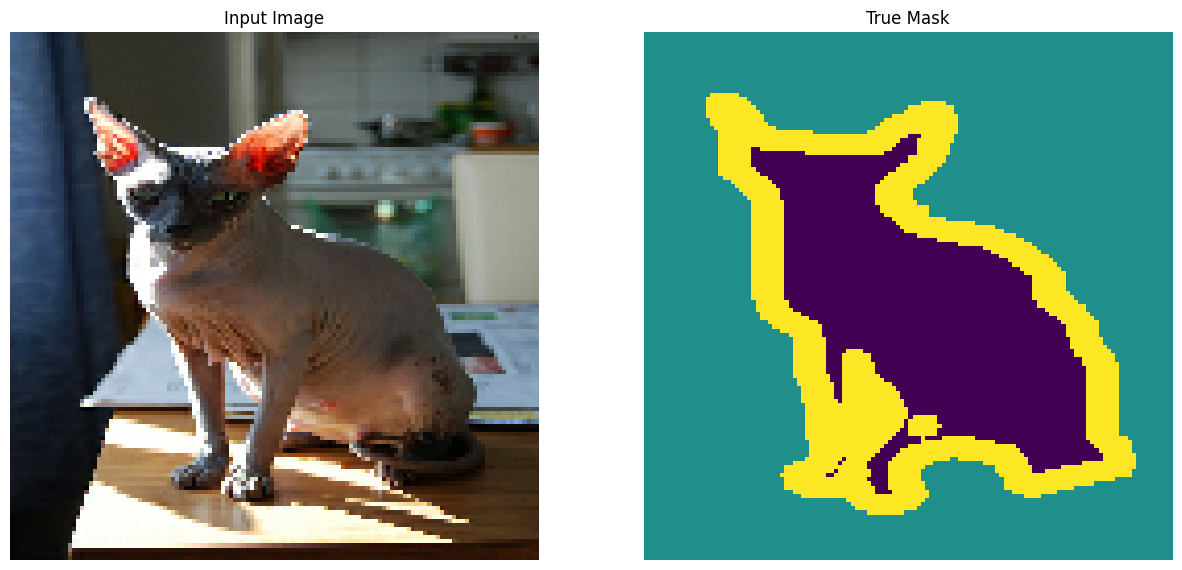

In [27]:
# Random Image to understand the data more
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [28]:
# Since we are going to use multiple covolution and maxpool layers, it is better to build some functions to make the code cleaner
def double_convolution_block(a, filters):
  a = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu",kernel_initializer="he_normal")(a)
  a = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu",kernel_initializer="he_normal")(a)
  return a

def downscale_block(a, filters):
  f = double_convolution_block(a, filters)
  a = tf.keras.layers.MaxPool2D(2)(f)
  a = tf.keras.layers.Dropout(rate=0.3)(a) # Dropout to lower ovrefitting
  return f,a # f needs to be saved for the skip connections later

def upscale_block(a, f, filters):
  a = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding="same")(a)
  a  = tf.keras.layers.Concatenate()([a,f])
  a  = tf.keras.layers.Dropout(rate=0.3)(a)
  a = double_convolution_block(a, filters)
  return a

In [14]:
# Now, using these helper functions, lets build a final unet funtion
def unet_function():
  input = tf.keras.layers.Input((128,128,3))
  # Downscaling
  f1, a1 = downscale_block(input, filters=64)
  f2, a2 = downscale_block(a1, filters=128)
  f3, a3 = downscale_block(a2, filters=256)
  f4, a4 = downscale_block(a3, filters=512)

  # Bottleneck
  a5 = double_convolution_block(a4, filters=1024)

  # Upscaling
  a6 = upscale_block(a5, f4, filters=512)
  a7 = upscale_block(a6, f3, filters=256)
  a8 = upscale_block(a7, f2, filters=128)
  a9 = upscale_block(a8, f1, filters=64)

  # Output Layer
  output = tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding='same', activation='softmax')(a9)

  unet_model = tf.keras.Model(input, output, name="U-net")
  return unet_model

In [15]:
unet_model = unet_function()

In [16]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")

In [29]:
# Get some hyperparameters
epochs = 30
TRAIN_SIZE = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_SIZE//BATCH_SIZE
VAL_SUBSPLITS = 5
VAL_SIZE = 3000
VALIDATION_STEPS = VAL_SIZE//BATCH_SIZE//VAL_SUBSPLITS

In [18]:
# Train the model
unet_model.fit(train_batches, epochs=epochs, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=validation_batches)

Epoch 1/30
57/57 [==============================] - 126s 1s/step - loss: 1.0016 - accuracy: 0.5697 - val_loss: 0.8619 - val_accuracy: 0.6037
Epoch 2/30
57/57 [==============================] - 85s 1s/step - loss: 0.7332 - accuracy: 0.6867 - val_loss: 0.6739 - val_accuracy: 0.7240
Epoch 3/30
57/57 [==============================] - 62s 1s/step - loss: 0.6670 - accuracy: 0.7286 - val_loss: 0.6483 - val_accuracy: 0.7400
Epoch 4/30
57/57 [==============================] - 62s 1s/step - loss: 0.5983 - accuracy: 0.7590 - val_loss: 0.5647 - val_accuracy: 0.7728
Epoch 5/30
57/57 [==============================] - 63s 1s/step - loss: 0.5538 - accuracy: 0.7816 - val_loss: 0.5148 - val_accuracy: 0.7974
Epoch 6/30
57/57 [==============================] - 61s 1s/step - loss: 0.5029 - accuracy: 0.8036 - val_loss: 0.4767 - val_accuracy: 0.8162
Epoch 7/30
57/57 [==============================] - 64s 1s/step - loss: 0.4661 - accuracy: 0.8200 - val_loss: 0.4397 - val_accuracy: 0.8313
Epoch 8/30
57/57 [=

In [30]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]
def show_predictions(dataset=None, num=1):
  for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])

2/2 [==============================] - 0s 165ms/step


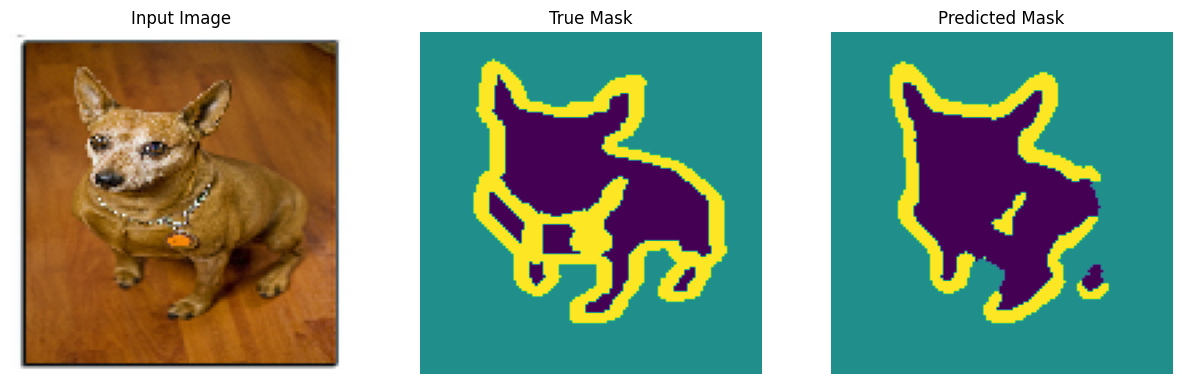

2/2 [==============================] - 0s 119ms/step


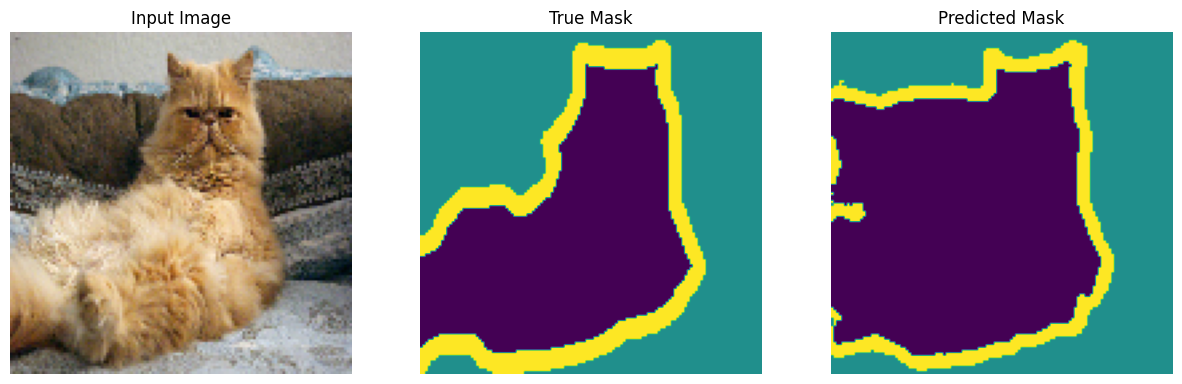

2/2 [==============================] - 0s 119ms/step


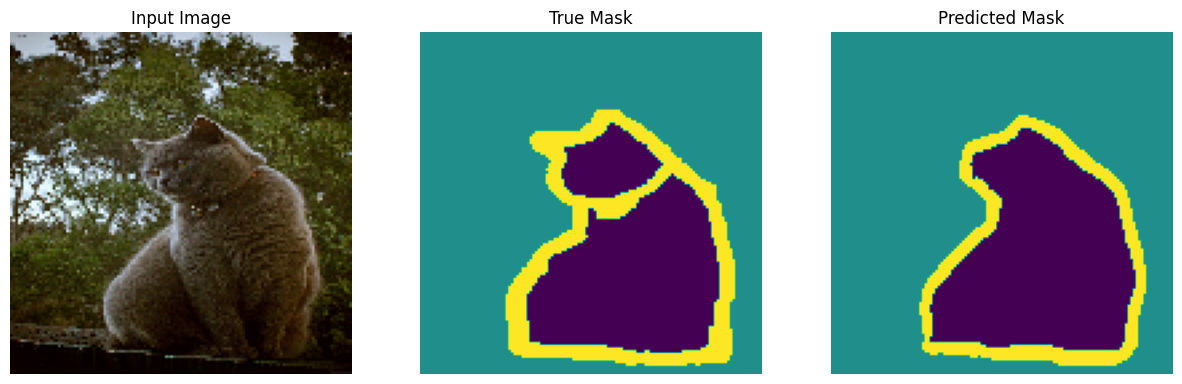

In [31]:
show_predictions(dataset=test_batches, num=3)

In [21]:
unet_model.save("my_unet.keras")

In [23]:
from google.colab import files
files.download('my_unet.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>